Import Necessary Library

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, LSTM
import keras
import keras.callbacks
from keras.callbacks import TensorBoard

Import Dataset

In [8]:
df = pd.read_csv('heart_rate_throughout_a_day.csv')
df

,time,value
0,00:00:01,61
1,00:00:06,63
2,00:00:16,62
3,00:00:26,63
4,00:00:41,63
...,...,...
10895,23:58:25,83
10896,23:58:30,83
10897,23:58:35,81
10898,23:58:40,78


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    10900 non-null  object
 1   value   10900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 170.4+ KB


Converting to float32

In [10]:
df['value'] = df['value'].astype(np.float32)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    10900 non-null  object 
 1   value   10900 non-null  float32
dtypes: float32(1), object(1)
memory usage: 127.9+ KB


In [12]:
df.isnull().sum()

time     0
value    0
dtype: int64

In [13]:
time = df['time'].values
value = df['value'].values

time = np.array(time)
value = np.array(value)

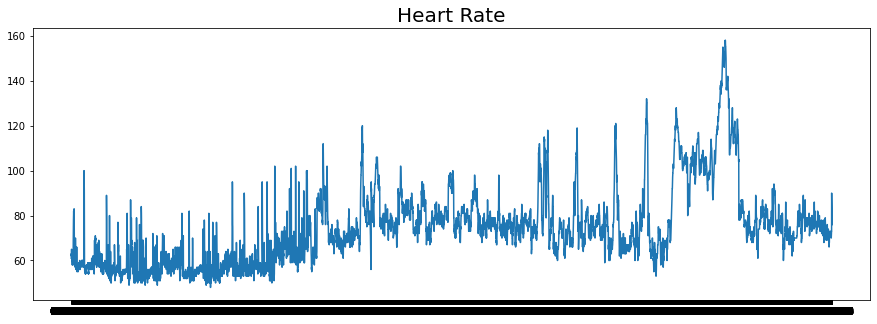

In [14]:
plt.figure(figsize = (15,5))
plt.plot(time, value)
plt.title('Heart Rate', fontsize=20);

In [15]:
split_time = int(len(time)*0.8)
time_train = time[:split_time]
value_train = value[:split_time]
time_val = time[split_time:]
value_val = value[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [16]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [17]:
train_set = windowed_dataset(value_train, window_size = 60, batch_size = 200, shuffle_buffer= 1000)

In [18]:
val_set = windowed_dataset(value_val, window_size = 60, batch_size = 200, shuffle_buffer= 1000)

In [19]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(LSTM(60)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [23]:
class realCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<10):
      print("\nMAE model less than 10% data scale.")
      self.model.stop_training = True
     

In [24]:
 callbacks = realCallback()

In [26]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-05, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, callbacks=[callbacks], validation_data= val_set)

Epoch 1/500
44/44 [==============================] - 21s 478ms/step - loss: 70.0258 - mae: 70.5258 - val_loss: 89.4957 - val_mae: 89.9957
Epoch 2/500
44/44 [==============================] - 20s 454ms/step - loss: 69.9542 - mae: 70.4542 - val_loss: 89.3974 - val_mae: 89.8974
Epoch 3/500
44/44 [==============================] - 20s 454ms/step - loss: 69.8610 - mae: 70.3610 - val_loss: 89.2559 - val_mae: 89.7559
Epoch 4/500
44/44 [==============================] - 21s 470ms/step - loss: 69.7813 - mae: 70.2813 - val_loss: 89.1044 - val_mae: 89.6044
Epoch 5/500
44/44 [==============================] - 20s 454ms/step - loss: 69.6892 - mae: 70.1892 - val_loss: 88.9437 - val_mae: 89.4437
Epoch 6/500
44/44 [==============================] - 22s 491ms/step - loss: 69.5805 - mae: 70.0805 - val_loss: 88.8253 - val_mae: 89.3253
Epoch 7/500
44/44 [==============================] - 20s 454ms/step - loss: 69.4854 - mae: 69.9854 - val_loss: 88.7179 - val_mae: 89.2179
Epoch 8/500
44/44 [===============

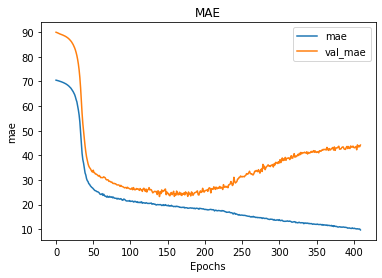

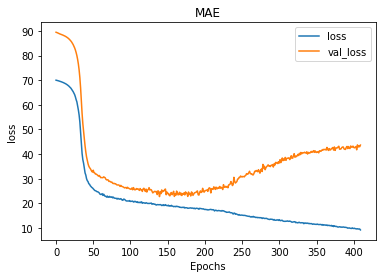

In [29]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title('MAE')
  plt.show()
  
plot_graphs(history, "mae")
plot_graphs(history, "loss")